### Spine Dataset Classification 

In [0]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import pandas as pd

In [0]:
%cd /content/drive/'My Drive'/

/content/drive/My Drive


In [0]:
orig_path = './Training'
normal_dir = os.path.join(orig_path, 'Normal')
damaged_dir = os.path.join(orig_path, 'Damaged')

# ids in the normal and damaged dir
normal_ids = os.listdir(normal_dir)
damaged_ids = os.listdir(damaged_dir)

#### Feeding Lists for Custom Dataset Class Pytorch
There are two types of input to this classifier, ie, the AP view and the LAT view. Based on the two images we need to make a classification

In [0]:
images_AP = []
images_LAT = []
labels = []

for id in normal_ids:
    AP_image_path = os.path.join(normal_dir, id, 'AP' , 'AP.jpg')
    LAT_image_path = os.path.join(normal_dir, id, 'LAT', 'LAT.jpg')
    images_AP.append(AP_image_path)
    images_LAT.append(LAT_image_path)
    labels.append(np.array([1, 0])) # normal case

for id in damaged_ids:
    AP_image_path = os.path.join(damaged_dir, id, 'AP' , 'AP.jpg')
    LAT_image_path = os.path.join(damaged_dir, id, 'LAT', 'LAT.jpg')
    images_AP.append(AP_image_path)
    images_LAT.append(LAT_image_path)
    labels.append(np.array([0, 1])) # damaged case

data_ap = pd.DataFrame({'Images' : images_AP, 'labels' : labels})
data_lat = pd.DataFrame({'Images' : images_LAT, 'labels' : labels})

In [0]:
validation_split = .2
shuffle_dataset = True
random_seed = 42

In [0]:
# We would be splitting both data_ap and data_lat in the same way
dataset_size = len(data_ap)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [0]:
# get sampler for dataloader
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [0]:
# these sizes would be later used in the train while calculating running losses and accuracy
dataset_size = {
    'train' : len(train_sampler),
    'validation' : len(valid_sampler)
} 

#### Create Custom Dataset : 
Our custom dataset would return two images at __getitem__ to enable multi-input functionality

In [0]:
# custom dataset for our dataset
class SpineDataset(torch.utils.data.Dataset):
    def __init__(self, ap_data, lat_data, transform=None):
        self.transform = transform
        self.ap_data = ap_data
        self.lat_data = lat_data
        
    def __len__(self):
        return len(self.ap_data)
    
    def __getitem__(self, index):
        ap = Image.open(self.ap_data.loc[index]['Images'])
        lat = Image.open(self.lat_data.loc[index]['Images'])
        label = torch.from_numpy(self.ap_data.loc[index]['labels']).type(torch.LongTensor)
        if self.transform is not None:
            ap = self.transform(ap)
            lat = self.transform(lat)
        return ap, lat, label

In [0]:
size = [224, 224]
# size = [299, 299] # for inception_v3 net input sizes to the model should be (299, 299)

transform = transforms.Compose(
    [
     transforms.Grayscale(num_output_channels=3),
     transforms.Resize(size),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet mean and std
     ]
      )

dataset = SpineDataset(data_ap, data_lat, transform = transform)

In [0]:
len(dataset)

678

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


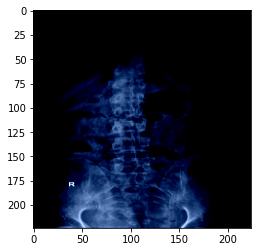

In [0]:
img = dataset.__getitem__(0)[0].permute(1, 2, 0)
plt.imshow(img)
plt.show()

In [0]:
img.shape

torch.Size([224, 224, 3])

In [0]:
batch_size = 8 # Output from the dataloader should be of the form (8, 3, 224, 224) or (8, 3, 299, 299) in the case of inception_v3 net

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=0)
dataloaders = {
    'train' : train_loader,
    'validation' : validation_loader
}

In [0]:
# just to visualize the dataloader shapes
dataiter = iter(train_loader)
*image, label = next(dataiter)

In [0]:
print ("Image would be a list consisting of two batches, one for AP(shape = {})\
 \n and one for LAT(shape = {}) and label batch shape is {}".format(image[0].shape, image[1].shape, label.shape))

Image would be a list consisting of two batches, one for AP(shape = torch.Size([8, 3, 224, 224])) 
 and one for LAT(shape = torch.Size([8, 3, 224, 224])) and label batch shape is torch.Size([8, 2])


In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional as F

In [0]:
model = models.vgg19(pretrained=True)
print (model) # to see how fc layer can be changed for transfer learning

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

#### Create Custom model
The CustomModel can be implemented with any kind of pretrained model. Because we have two inputs, I have used (1 * 1) convolution to get weighted inputs from both the image to construct one image. This one image would be used as inputs to the pretrained classifier. The final Linear layer has been changed to our problem of a binary class classfication with a log softmax probablities

In [0]:

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.conv = nn.Conv2d(3, 3, 1)
        # change here if any other pretrained model needs to be implemented
        self.model = models.resnet34(pretrained=True).to(device)

        for param in self.model.parameters():
            param.requires_grad = False

        # To add a trainable FC layer in the end, self.model.fc might not work for all the cases
        # check how it needs to be added using print (model). 

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
               nn.Linear(num_ftrs, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2),
               nn.LogSoftmax(dim=1)).to(device)

    def forward(self, x1, x2):
        x1 = self.conv(x1)
        x2 = self.conv(x2)

        x = x1 + x2
        x = self.model(x)
        return x

In [0]:
model = CustomModel()

In [0]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

262542

In [0]:
def train_model(model, criterion, optimizer, num_epochs=3):

    best_acc = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for *inputs, labels in dataloaders[phase]:
                ap_batch = inputs[0].to(device)
                lat_batch = inputs[1].to(device)
                labels = labels.to(device)

                outputs = model(ap_batch, lat_batch)
                # print (outputs[0])

                loss = criterion(outputs, torch.max(labels, 1)[1])

                # # for the inception net case comment out the upper loss and use the
                # # one below because it creates a inceptionOutput object while training
                # if phase == 'validation':
                #     loss = criterion(outputs, torch.max(labels, 1)[1])
                # else:
                #     loss = criterion(outputs[0], torch.max(labels, 1)[1])

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # # for the inception_net case
                # if phase == 'validation':
                #     _, preds = torch.max(outputs, 1)
                # else:
                #     _, preds = torch.max(outputs[0], 1)

                _, preds = torch.max(outputs, 1)

                # print (torch.max(labels, 1)[1])
                running_loss += loss.item() * ap_batch.size(0)
                running_corrects += torch.sum(preds == torch.max(labels, 1)[1])
            
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() /  dataset_size[phase]

            if phase == 'validation':
                is_best = epoch_acc > best_acc
                best_acc = max(epoch_acc, best_acc)

                if is_best:
                    torch.save(model.state_dict(), './resnet50_weights.h5')
                    print ("Model saved at Val Accuracy : ", best_acc)
                
          
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
    return model

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.NLLLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
model = model.to(device)
model = train_model(model, criterion, optimizer, num_epochs=30)

Epoch 1/30
----------
train loss: 0.6710, acc: 0.5856
Model saved at Val Accuracy :  tensor(0.5852, device='cuda:0', dtype=torch.float64)
validation loss: 0.6480, acc: 0.5852
Epoch 2/30
----------
train loss: 0.6194, acc: 0.6575
Model saved at Val Accuracy :  tensor(0.7926, device='cuda:0', dtype=torch.float64)
validation loss: 0.5539, acc: 0.7926
Epoch 3/30
----------
train loss: 0.5578, acc: 0.7422
validation loss: 0.4787, acc: 0.7778
Epoch 4/30
----------
train loss: 0.5988, acc: 0.6703
Model saved at Val Accuracy :  tensor(0.8444, device='cuda:0', dtype=torch.float64)
validation loss: 0.4830, acc: 0.8444
Epoch 5/30
----------
train loss: 0.5034, acc: 0.7680
validation loss: 0.4999, acc: 0.7407
Epoch 6/30
----------
train loss: 0.4850, acc: 0.7680
Model saved at Val Accuracy :  tensor(0.8519, device='cuda:0', dtype=torch.float64)
validation loss: 0.4075, acc: 0.8519
Epoch 7/30
----------
train loss: 0.4788, acc: 0.7808
validation loss: 0.3967, acc: 0.8222
Epoch 8/30
----------
train

KeyboardInterrupt: ignored

In [0]:
model = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
train loss: 0.4074, acc: 0.7993
Model saved at Val Accuracy :  tensor(0.8148, device='cuda:0', dtype=torch.float64)
validation loss: 0.3948, acc: 0.8148
Epoch 2/20
----------
train loss: 0.3590, acc: 0.8398
validation loss: 0.4362, acc: 0.8148
Epoch 3/20
----------
train loss: 0.3574, acc: 0.8453
Model saved at Val Accuracy :  tensor(0.8296, device='cuda:0', dtype=torch.float64)
validation loss: 0.3849, acc: 0.8296
Epoch 4/20
----------
train loss: 0.3569, acc: 0.8140
validation loss: 0.3991, acc: 0.8296
Epoch 5/20
----------
train loss: 0.3482, acc: 0.8471
validation loss: 0.4268, acc: 0.8074
Epoch 6/20
----------
train loss: 0.3422, acc: 0.8398
validation loss: 0.4504, acc: 0.7778
Epoch 7/20
----------
train loss: 0.3451, acc: 0.8527
validation loss: 0.5216, acc: 0.7259
Epoch 8/20
----------
train loss: 0.3637, acc: 0.8306
validation loss: 0.3982, acc: 0.8000
Epoch 9/20
----------
train loss: 0.3339, acc: 0.8656
validation loss: 0.3999, acc: 0.8222
Epoch 10/20
-

In [0]:
torch.save(model.state_dict(), './weights.h5')

#### Ensemble of models to improve model predictions

In [0]:
model_resnet50 = CustomModel()
model_resnet50.load_state_dict(torch.load('./resnet50_weights.h5'))

<All keys matched successfully>

In [0]:
model_resnet34 = CustomModel()
model_resnet34.load_state_dict(torch.load('./resnet34_weights.h5'))

<All keys matched successfully>

In [0]:
model_vgg19 = CustomModel()
model_vgg19.load_state_dict(torch.load('./vgg19_weights.h5'))

<All keys matched successfully>

In [0]:
model_vgg16 = CustomModel()
model_vgg16.load_state_dict(torch.load('./vgg16_weights.h5'))

<All keys matched successfully>

In [0]:
model_resnet50.eval()
model_resnet50.to(device)

model_resnet34.eval()
model_resnet34.to(device)

model_vgg19.eval()
model_vgg19.to(device)

model_vgg16.eval()
model_vgg16.to(device)

running_corrects = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for *inputs, labels in validation_loader:
    ap_batch = inputs[0].to(device)
    lat_batch = inputs[1].to(device)
    labels = labels.to(device)

    outputs_vgg16 = model_vgg16(ap_batch, lat_batch)
    outputs_vgg19 = model_vgg19(ap_batch, lat_batch)
    outputs_resnet34 = model_resnet34(ap_batch, lat_batch)
    outputs_resnet50 = model_resnet50(ap_batch, lat_batch)

    outputs = (outputs_vgg16 + outputs_vgg19 + outputs_resnet34 + outputs_resnet50)/4
    _, preds = torch.max(outputs, 1)

    # print (torch.max(labels, 1)[1])
    running_corrects += torch.sum(preds == torch.max(labels, 1)[1])

print (running_corrects.double() /  dataset_size['validation'])

tensor(0.8519, device='cuda:0', dtype=torch.float64)
